In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

from cryoet.data.parsers import get_volume_and_objects

In [34]:
root = "./data"

study = "TS_5_4"
mode = "denoised"

In [35]:
volume_data, object_centers, object_labels, object_radii = get_volume_and_objects(
    root_dir=root,
    study_name=study,
    mode=mode,
    split="train",
)

In [36]:
volume_data.min(), volume_data.mean(), volume_data.std(), volume_data.max()

(-0.00032409787, 2.06502e-07, 7.438237e-06, 0.00015229516)

In [37]:
from cryoet.data.parsers import visualize_slices_grid

In [38]:
# fig

In [39]:
indx = 3
object_centers[indx]

array([5880.769, 1125.348,  579.56 ], dtype=float32)

In [40]:
volume_data.shape

(184, 630, 630)

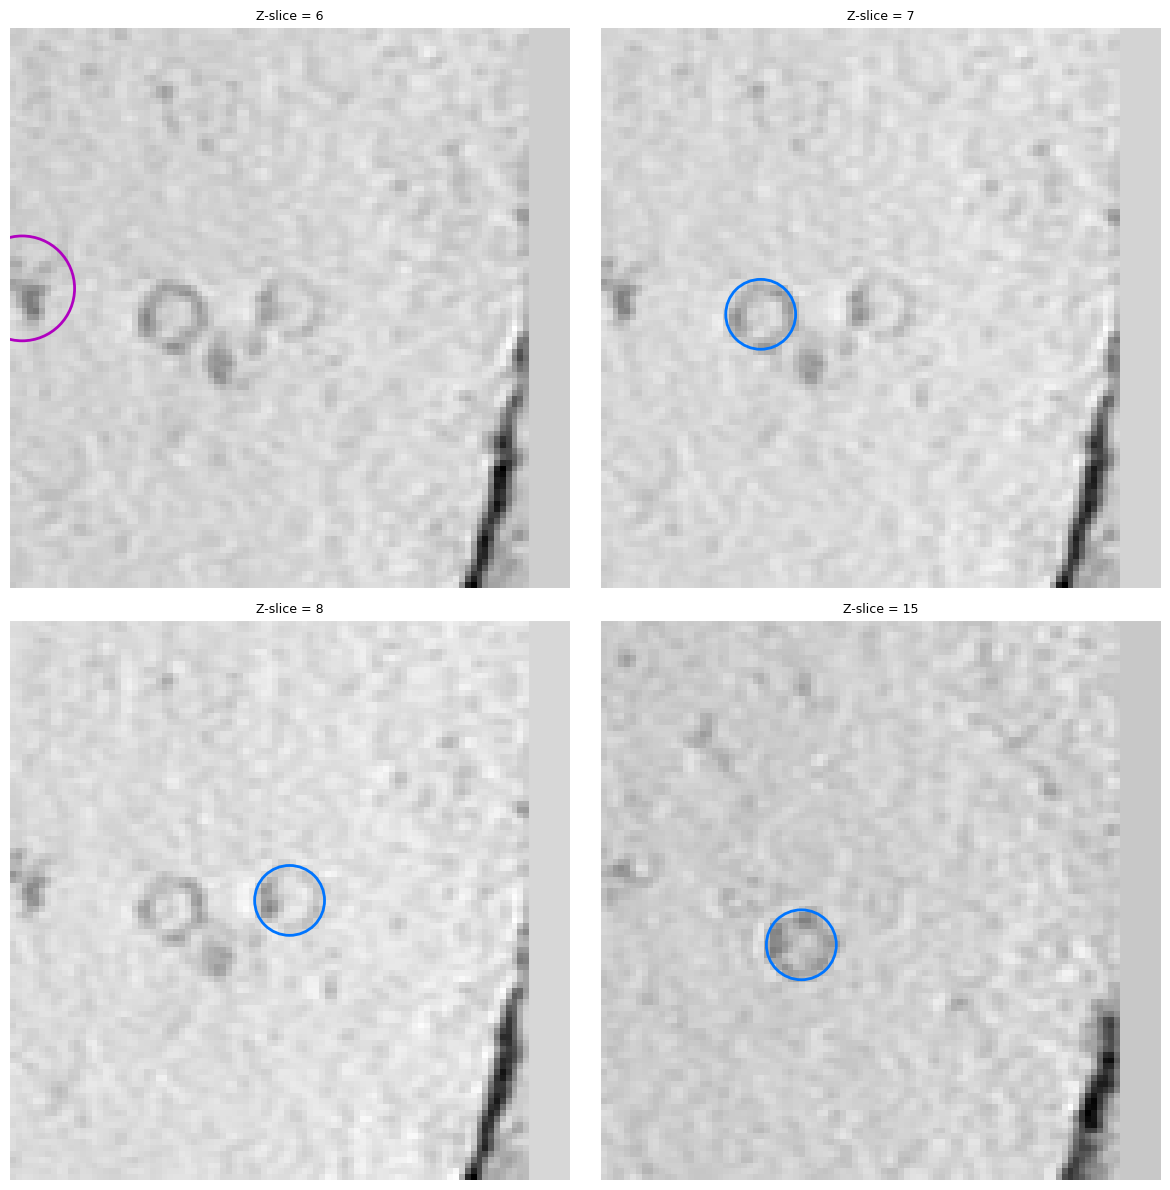

In [41]:
from cryoet.data.augmentations.functional import get_points_mask_within_cube, rotate_and_scale_volume

object_centers_px = object_centers / 10.0

scale = 1.0
rotated_volume1, rotated_centers1 = rotate_and_scale_volume(
    volume=volume_data,
    points=object_centers_px,
    scale=scale,
    angles=(0, 0, 0),
    center_zyx=(object_centers_px[indx,2], object_centers_px[indx,1], object_centers_px[indx,0]),
    output_shape=(16, 96, 96),
)

mask = get_points_mask_within_cube(rotated_centers1, rotated_volume1.shape)

fig = visualize_slices_grid(
    rotated_volume1, rotated_centers1[mask], object_labels[mask], object_radii[mask] * scale / 10,
    slices_to_show=None,
    only_slices_with_objects=True,
    voxel_size=1.0,
    ncols=2,
)


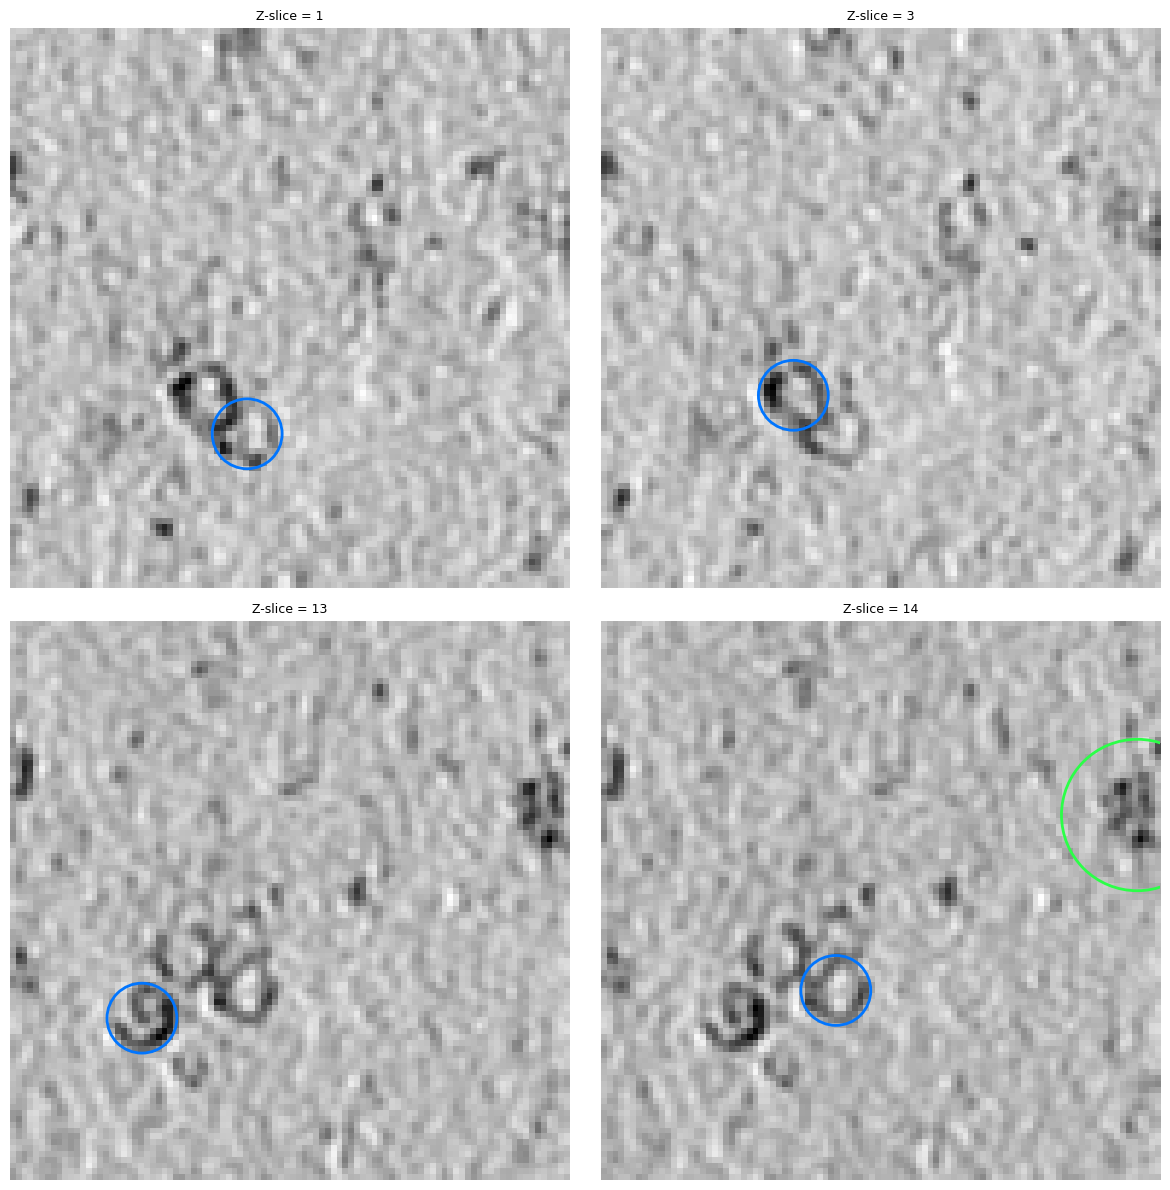

In [42]:
indx2 = 10

rotated_volume2, rotated_centers2 = rotate_and_scale_volume(
    volume=volume_data,
    points=object_centers_px,
    scale=scale,
    angles=(0, 0, 0),
    center_zyx=(object_centers_px[indx2,2] + 5, object_centers_px[indx2,1] + 15, object_centers_px[indx2,0] + 15),
    output_shape=(16, 96, 96),
)
mask2 = get_points_mask_within_cube(rotated_centers2, rotated_volume2.shape)

fig = visualize_slices_grid(
    rotated_volume2, rotated_centers2[mask2], object_labels[mask2], object_radii[mask2] * scale / 10,
    slices_to_show=None,
    only_slices_with_objects=True,
    voxel_size=1.0,
    ncols=2,
)


In [43]:
from scipy import ndimage
import numpy as np

def merge_volume_using_derivatives(volume1, volume2):
    """
    Compute dx, dy, dz derivatives for volume2 and apply them to volume1.
    """
    return volume1 + (volume2 - volume2.mean())

def merge_volume_using_grad_mag(volume1, volume2):
    """
    Compute the gradient magnitude for volume2 in each pixel and use it as weights for blending.
    """
    dx = ndimage.sobel(volume1, 0) ** 2  # x derivative
    dy = ndimage.sobel(volume1, 1) ** 2  # y derivative
    dz = ndimage.sobel(volume1, 2) ** 2  # z derivative
    grad_mag1 = np.sqrt(dx + dy + dz)

    dx = ndimage.sobel(volume2, 0) ** 2  # x derivative
    dy = ndimage.sobel(volume2, 1) ** 2  # y derivative
    dz = ndimage.sobel(volume2, 2) ** 2  # z derivative
    grad_mag2 = np.sqrt(dx + dy + dz)

    return (volume1 * grad_mag1 + (volume2 - volume2.mean()) * grad_mag2) / (grad_mag1 + grad_mag2 + 1e-6)



def merge_volume_using_mean(volume1, volume2):
    """
    Compute dx, dy, dz derivatives for volume2 and apply them to volume1.
    """
    return volume1 * 0.5 + volume2 * 0.5

def merge_volume_using_max(volume1, volume2):
    """
    Compute dx, dy, dz derivatives for volume2 and apply them to volume1.
    """
    return np.maximum(volume1, volume2)


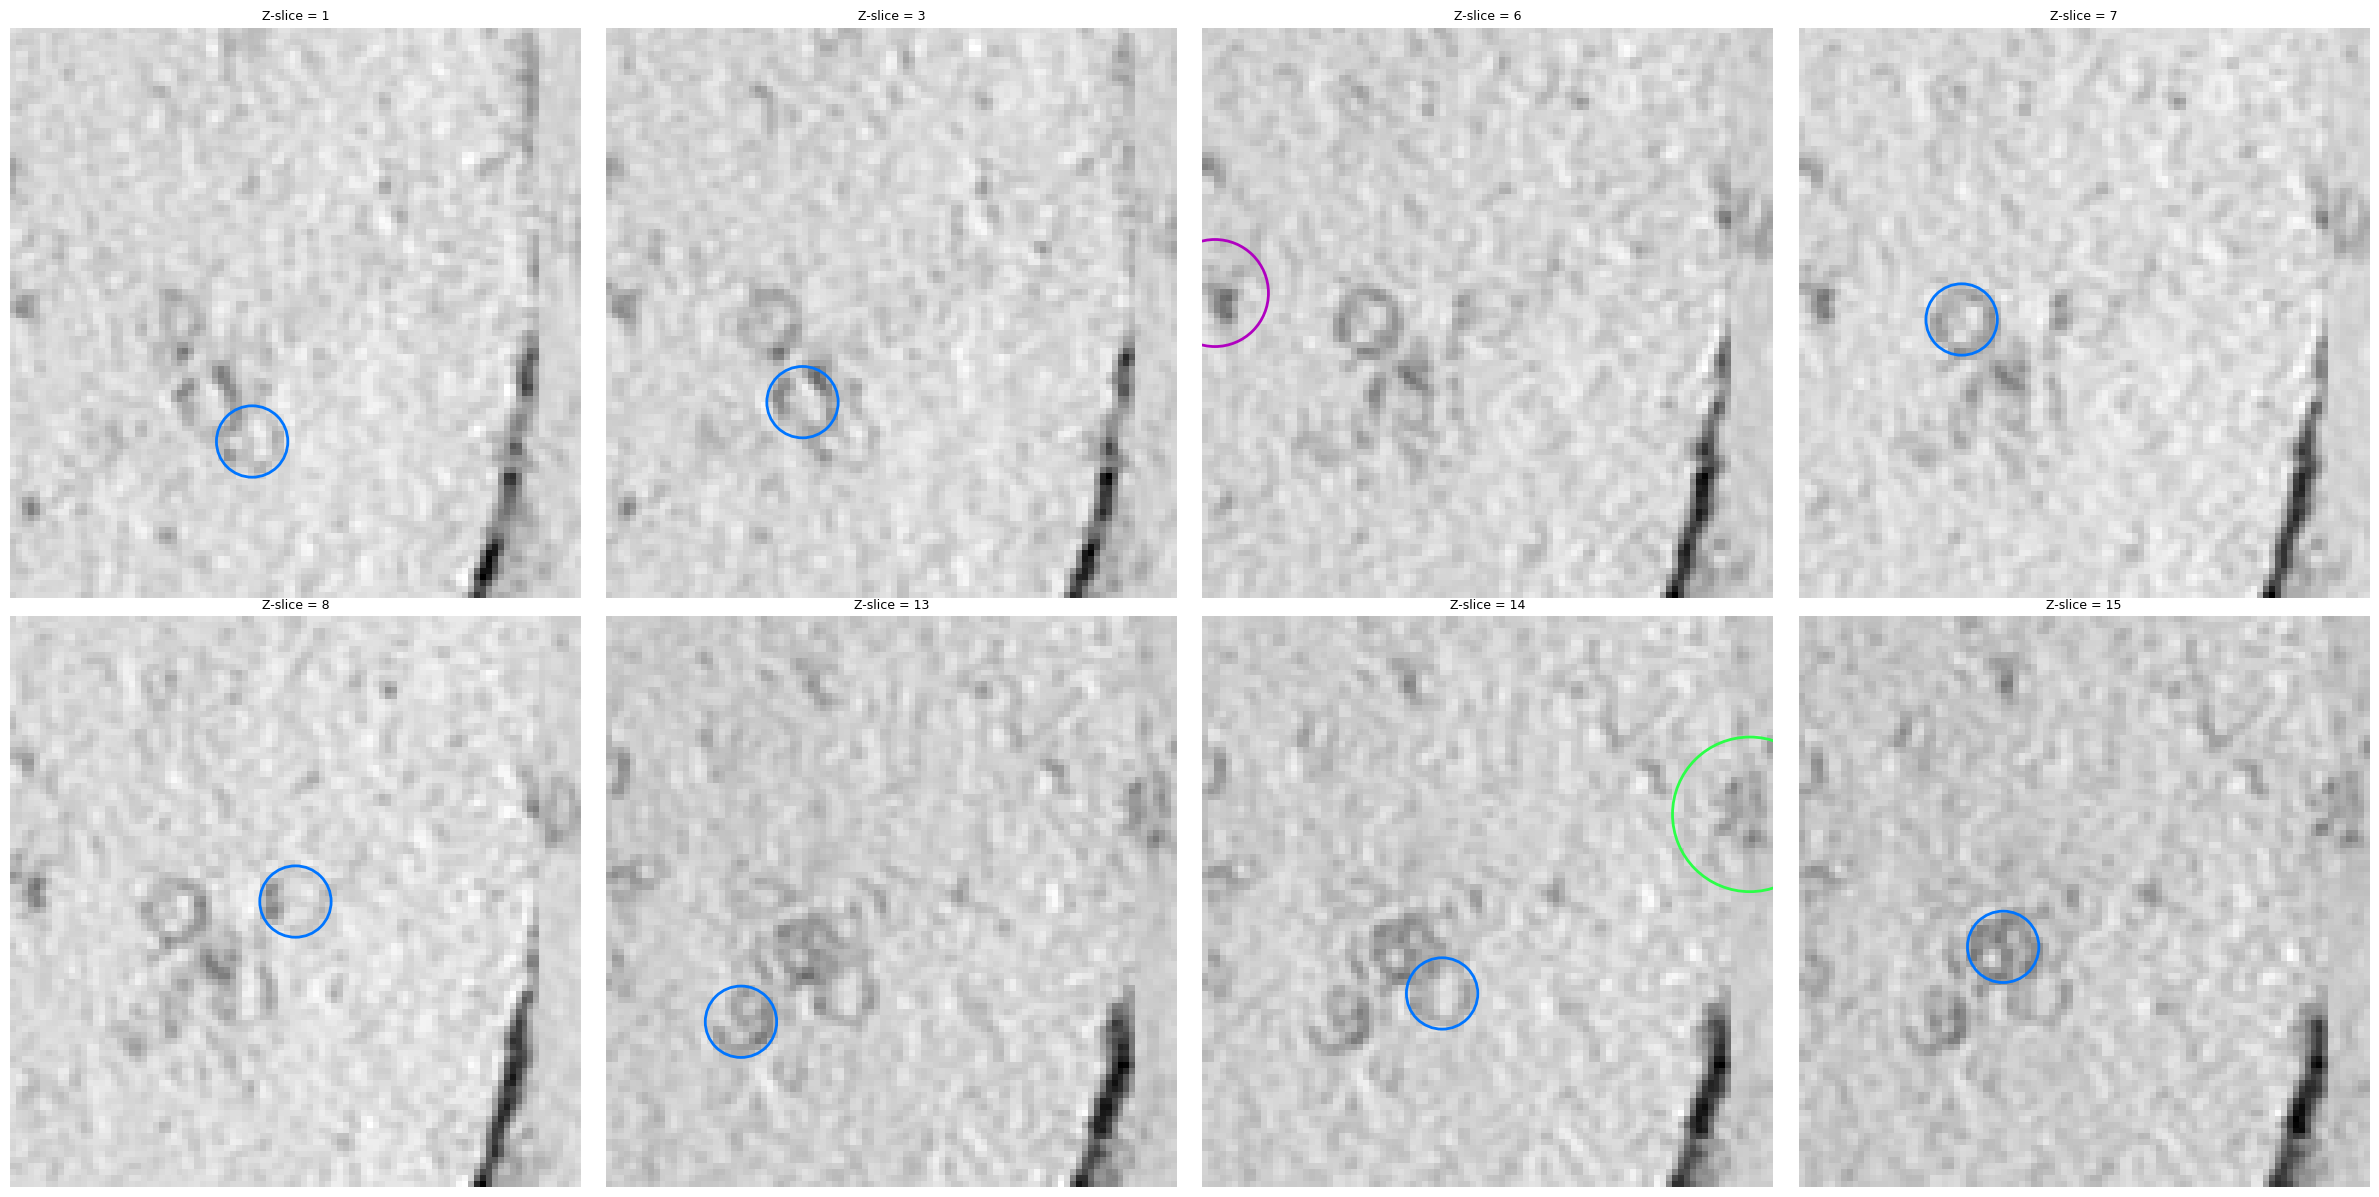

In [44]:
fig = visualize_slices_grid(
    merge_volume_using_derivatives(rotated_volume2, rotated_volume1),
    np.concatenate([rotated_centers2[mask2], rotated_centers1[mask]],axis=0),
    np.concatenate([object_labels[mask2], object_labels[mask]],axis=0),
    np.concatenate([object_radii[mask2] * scale / 10, object_radii[mask] * scale / 10],axis=0),
    slices_to_show=None,
    only_slices_with_objects=True,
    voxel_size=1.0,
    ncols=4,
)

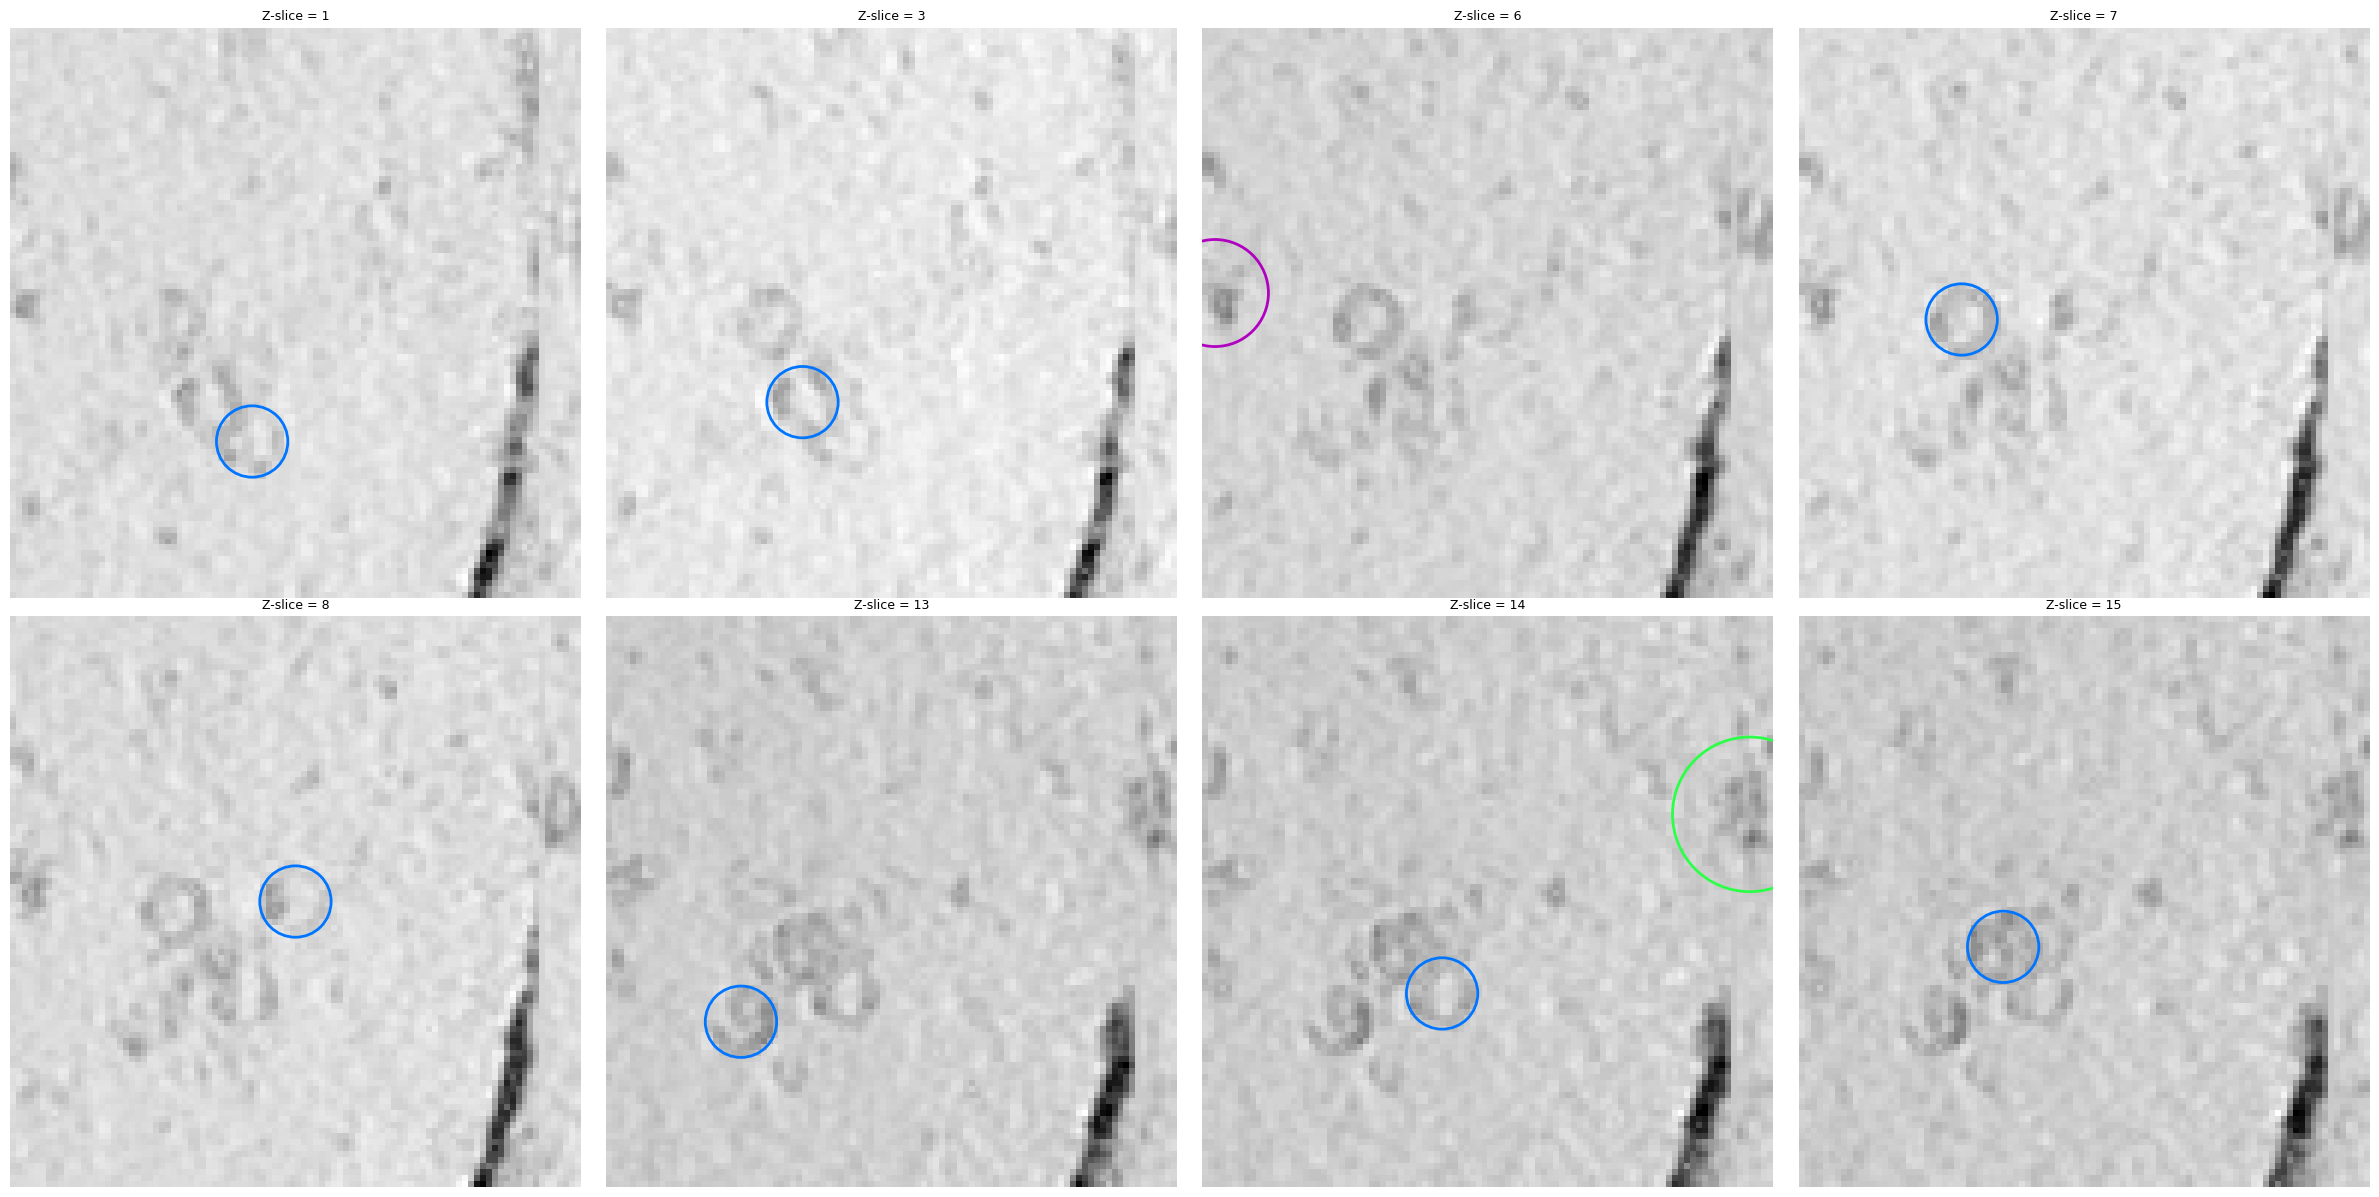

In [45]:
fig = visualize_slices_grid(
    merge_volume_using_grad_mag(rotated_volume2, rotated_volume1),
    np.concatenate([rotated_centers2[mask2], rotated_centers1[mask]],axis=0),
    np.concatenate([object_labels[mask2], object_labels[mask]],axis=0),
    np.concatenate([object_radii[mask2] * scale / 10, object_radii[mask] * scale / 10],axis=0),
    slices_to_show=None,
    only_slices_with_objects=True,
    voxel_size=1.0,
    ncols=4,
)

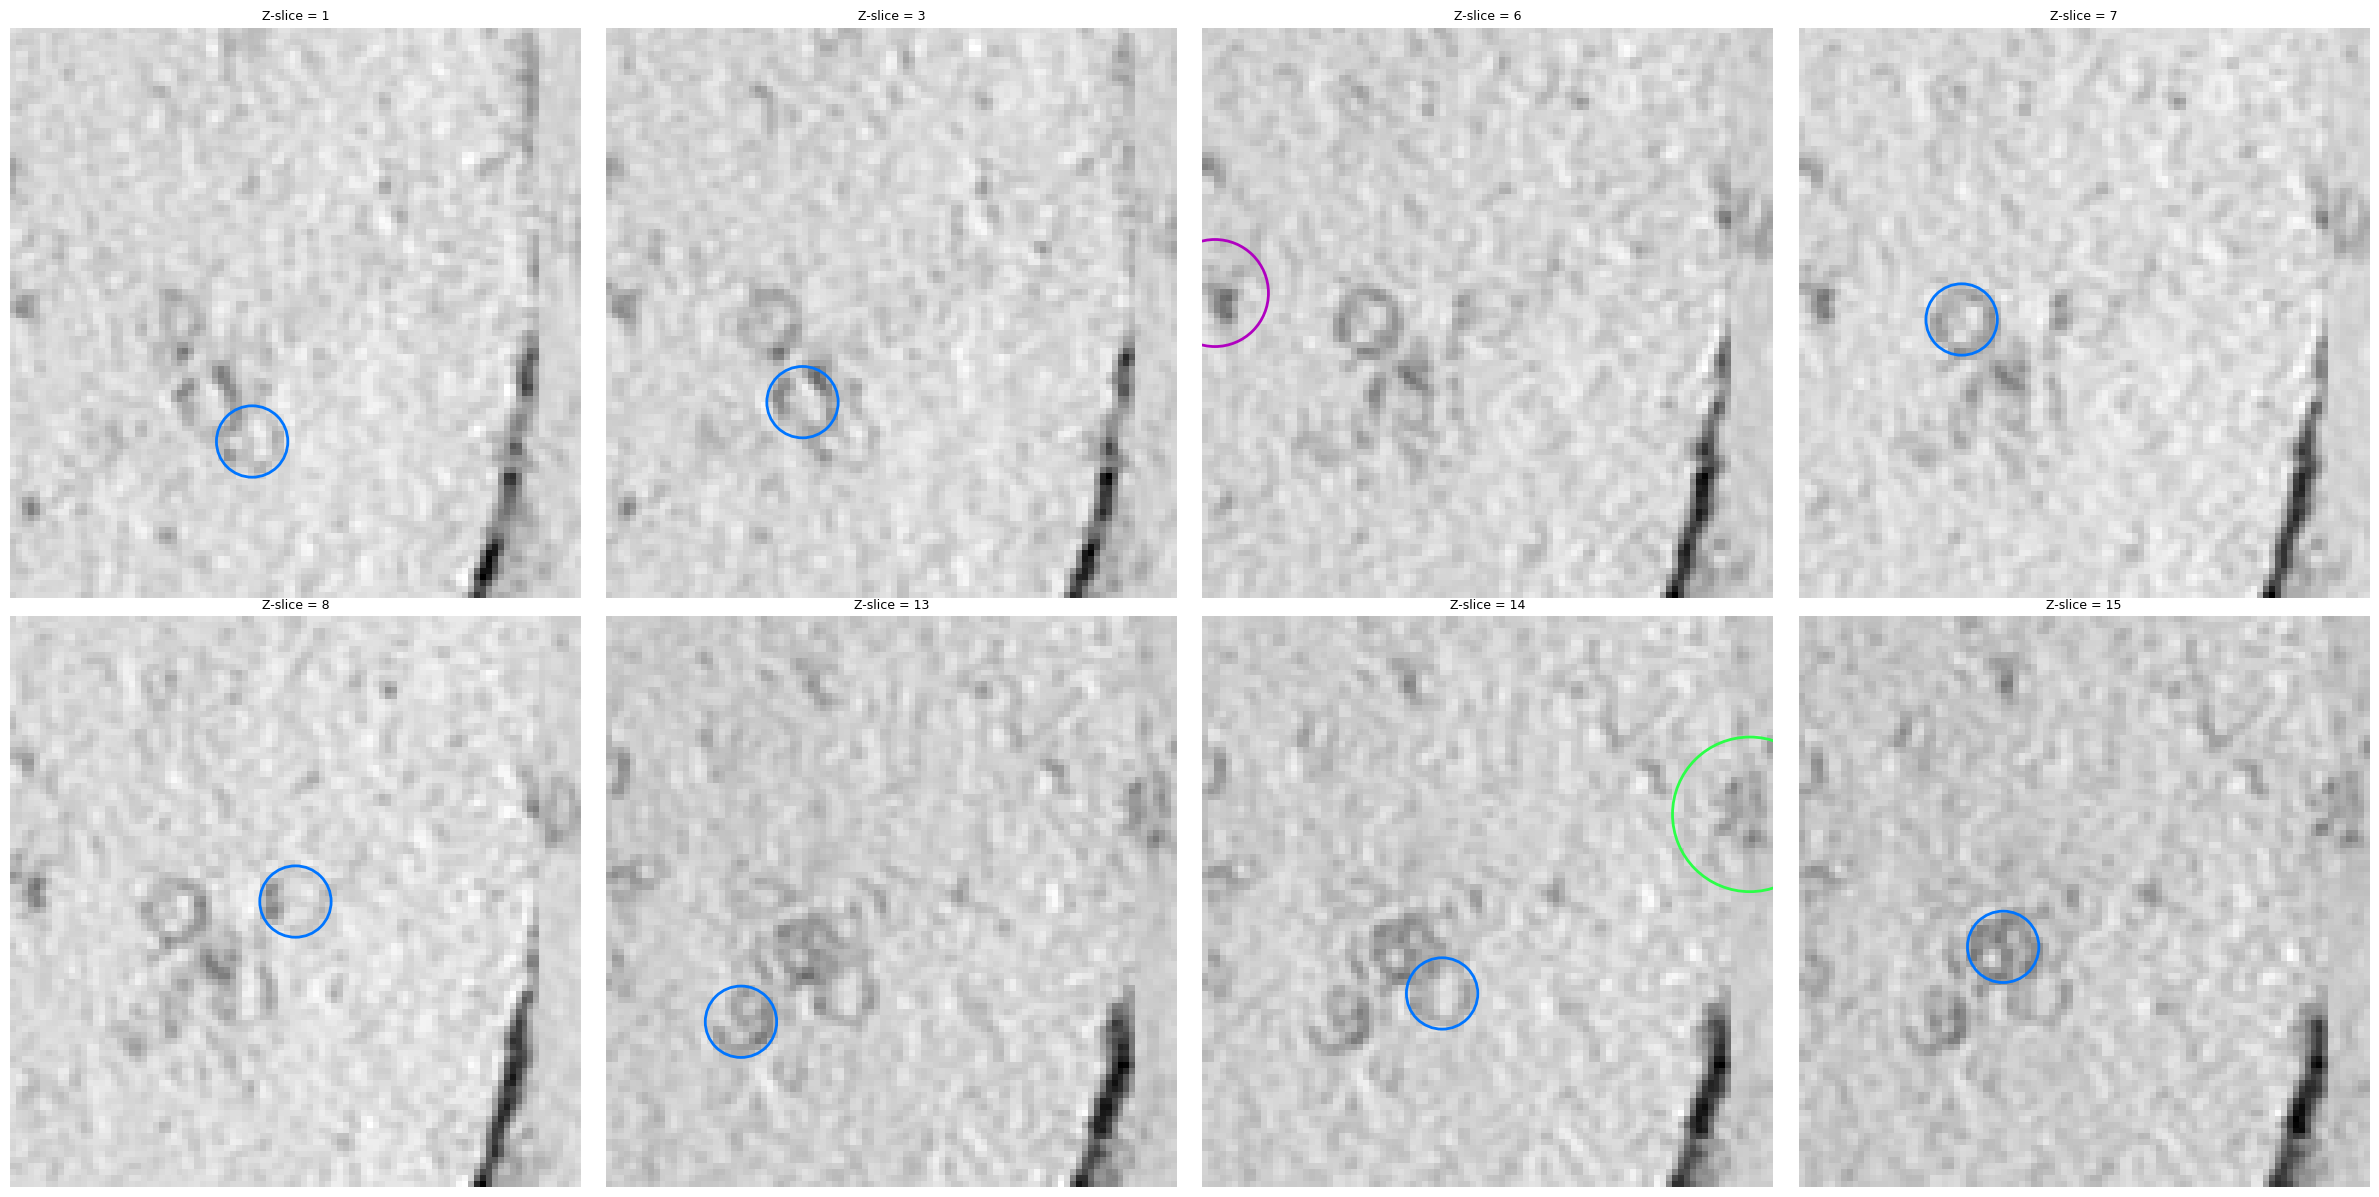

In [46]:
fig = (visualize_slices_grid
(
    merge_volume_using_mean(rotated_volume2, rotated_volume1),
    np.concatenate([rotated_centers2[mask2], rotated_centers1[mask]],axis=0),
    np.concatenate([object_labels[mask2], object_labels[mask]],axis=0),
    np.concatenate([object_radii[mask2] * scale / 10, object_radii[mask] * scale / 10],axis=0),
    slices_to_show=None,
    only_slices_with_objects=True,
    voxel_size=1.0,
    ncols=4,
))

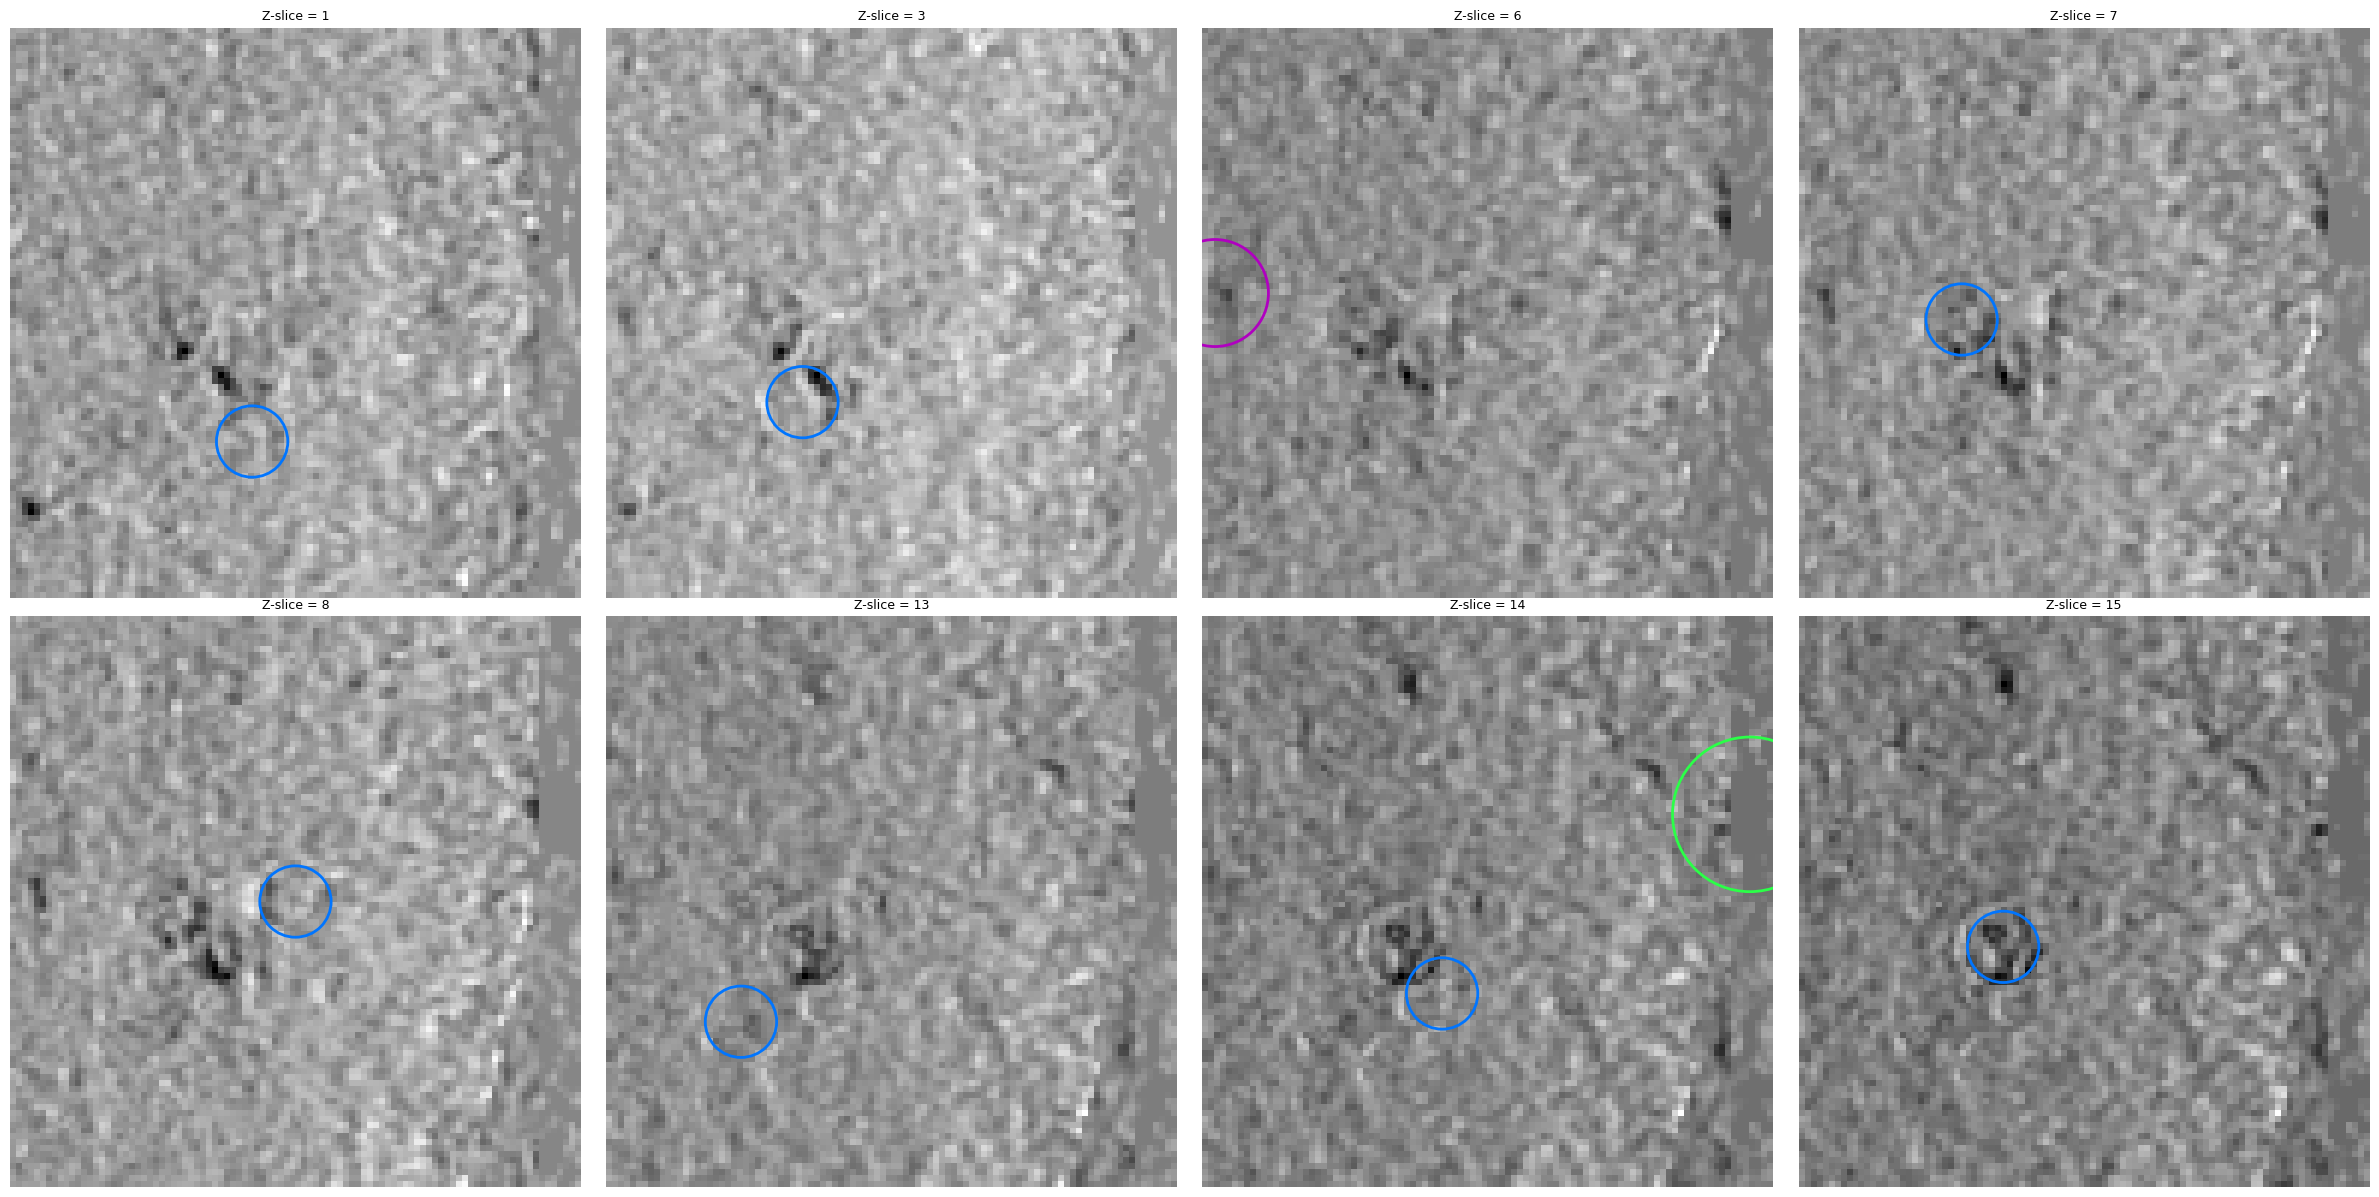

In [47]:
fig = visualize_slices_grid(
    merge_volume_using_max(rotated_volume2, rotated_volume1),
    np.concatenate([rotated_centers2[mask2], rotated_centers1[mask]],axis=0),
    np.concatenate([object_labels[mask2], object_labels[mask]],axis=0),
    np.concatenate([object_radii[mask2] * scale / 10, object_radii[mask] * scale / 10],axis=0),
    slices_to_show=None,
    only_slices_with_objects=True,
    voxel_size=1.0,
    ncols=4,
)